In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("https://raw.githubusercontent.com/C241-PR543-team/machine-learning/master/destinasi-wisata-indonesia.csv", sep=';')

In [3]:
import re

places = {}

with open('/content/places.txt', 'r') as file:
    for line in file:
        matches = re.split(r'\s*:\s*', line.strip())
        # Cek split berhasil atau tidak
        if len(matches) == 2:
            key = matches[0]
            value = matches[1].split(',')
            if len(value) > 1:
                value = [re.sub(r'\s+', ' ', v.strip()) for v in value]
            places[key] = value
        else:
            print(f"Invalid input format: {line}")
print(places)

{'Monumen Nasional': ['Budaya', 'Keluarga'], 'Kota Tua': ['Budaya'], 'Dunia Fantasi': ['Hiburan', 'Keluarga'], 'Taman Mini Indonesia Indah (TMII)': ['Budaya', 'Hiburan'], 'Atlantis Water Adventure': ['Petualangan', 'Hiburan'], 'Taman Impian Jaya Ancol': ['Hiburan', 'Keluarga'], 'Kebun Binatang Ragunan': ['Keluarga', 'Alam'], 'Ocean Ecopark': ['Petualangan', 'Alam'], 'Pelabuhan Marina': ['Hiburan', 'Alam'], 'Pulau Tidung': ['Alam', 'Petualangan'], 'Pulau Bidadari': ['Alam', 'Romantis'], 'Pulau Pari': ['Alam', 'Petualangan'], 'Pulau Pramuka': ['Alam', 'Petualangan'], 'Pulau Pelangi': ['Alam', 'Romantis'], 'Pasar Seni': ['Budaya', 'Hiburan'], 'Jembatan Kota Intan': ['Budaya'], 'Museum Fatahillah': ['Budaya'], 'Museum Bank Indonesia': ['Budaya'], 'Kidzania': ['Hiburan', 'Keluarga'], 'Museum Taman Prasasti': ['Budaya'], 'Museum Wayang': ['Budaya'], 'Masjid Istiqlal': ['Budaya'], 'Gereja Katedral': ['Budaya'], 'Museum Nasional': ['Budaya'], 'Pasar Tanah Abang': ['Budaya'], 'Pecinan Glodok': 

In [4]:
# New category
for index, row in df.iterrows():
    name = row['Place_Name']
    df['Category'] = df.apply(lambda row: places[row['Place_Name']] if row['Place_Name'] in places else None, axis=1)
    df["Category"] = df["Category"].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

In [5]:
# Filtering None
categories_array = categories_array[~pd.isnull(df["Category"].unique())]

categories_list = [cat.split(', ') for cat in categories_array]
unique_categories = set(category for sublist in categories_list for category in sublist)

category_string = ', '.join(unique_categories)
print(category_string)

Belanja, Edukasi, Kuliner, Religius, Petualangan, Hiburan, Relaksasi, Romantis, Keluarga, Sejarah, Pemandangan, Olahraga, Seni, Alam, Budaya, Makanan


In [6]:
df['Category'] = df['Category'].str.replace('Olahraga', 'Relaksasi')
df['Category'] = df['Category'].str.replace('Kuliner', 'Belanja')
df['Category'] = df['Category'].str.replace('Makanan', 'Belanja')
df['Category'] = df['Category'].str.replace('Romantis', 'Keluarga')
df['Category'] = df['Category'].str.replace('Pemandangan', 'Alam')
df['Category'] = df['Category'].str.replace('Edukasi', 'Sejarah')
df['Category'] = df['Category'].str.replace('Seni', 'Budaya')

In [8]:
df.iloc[df.index[df['Category'].isna()]]

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Rating_Count
210,211,GunungTangkuban perahu,Gunung Tangkuban Parahu adalah salah satu gunu...,None,Bandung,30000.0,45.0,NaN,"{'lat': -6.759637700000001, 'lng': 107.6097807}",-67596377.0,1.076098e+09,28.0


In [9]:
df['Category'].fillna("Alam", inplace=True)

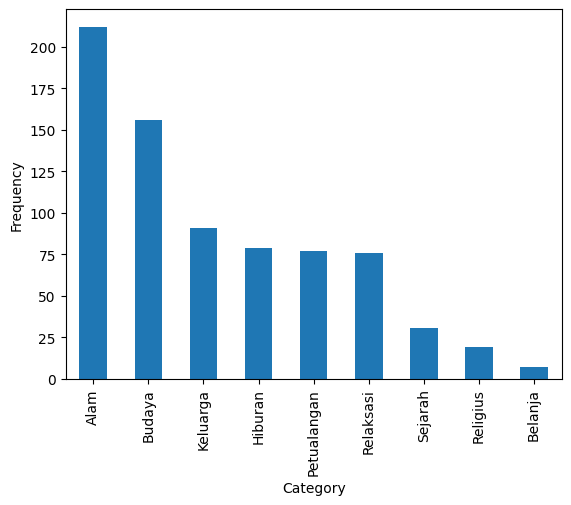

In [13]:
category = df['Category'].str.split(', ').sum()
counts = pd.Series(category).value_counts()

counts.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

In [14]:
def recommendation(city, categories):
    data = df[(df['City'] == city) & (df['Category'].str.contains('|'.join(categories), case=False, na=False))]
    if data.empty:
        return "Tidak ada tempat wisata dalam kategori yang dicari di kota ini."
    data.reset_index(drop=True, inplace=True)

    # Convert each place name into vectors using TF-IDF and bigram
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df=1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['Place_Name'])

    # Calculate the similarity between place names using cosine similarity
    sg = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Get the index corresponding to place names
    sig = list(enumerate(sg[-1]))
    sig = sorted(sig, key=lambda x: x[1], reverse=True)

    # Top 5 recommendations
    top_5_indices = [i[0] for i in sig[1:11]]
    recommendations = data.iloc[top_5_indices][['Place_Name', 'City', "Price"]]

    return recommendations

In [20]:
recommendation("Jakarta", ['Budaya'])

,Place_Name,City,Price
0,Monumen Nasional,Jakarta,20000.0
1,Kota Tua,Jakarta,0.0
2,Taman Mini Indonesia Indah (TMII),Jakarta,10000.0
3,Pasar Seni,Jakarta,0.0
4,Jembatan Kota Intan,Jakarta,0.0
5,Museum Fatahillah,Jakarta,5000.0
6,Museum Bank Indonesia,Jakarta,2000.0
7,Museum Taman Prasasti,Jakarta,2000.0
8,Museum Wayang,Jakarta,5000.0
9,Masjid Istiqlal,Jakarta,0.0


In [15]:
recommendation("Yogyakarta", ['Keluarga', 'Alam'])

,Place_Name,City,Price
0,Taman Pintar Yogyakarta,Yogyakarta,6000.0
1,Sindu Kusuma Edupark (SKE),Yogyakarta,20000.0
2,Gembira Loka Zoo,Yogyakarta,60000.0
3,Desa Wisata Sungai Code Jogja Kota,Yogyakarta,0.0
4,Taman Pelangi Yogyakarta,Yogyakarta,15000.0
5,Tebing Breksi,Yogyakarta,20000.0
6,Candi Donotirto,Yogyakarta,0.0
7,Embung Tambakboyo,Yogyakarta,0.0
8,Hutan Pinus Pengger,Yogyakarta,3000.0
9,Puncak Pinus Becici,Yogyakarta,3000.0


In [19]:
recommendation("Bandung", ['Relaksasi', 'Petualangan', 'Hiburan'])

,Place_Name,City,Price
0,Trans Studio Bandung,Bandung,280000.0
1,Taman Hutan Raya Ir. H. Djuanda,Bandung,15000.0
2,Farm House Susu Lembang,Bandung,30000.0
3,Kebun Binatang Bandung,Bandung,20000.0
4,Kawah Putih,Bandung,81000.0
5,Tebing Karaton,Bandung,15000.0
6,Dusun Bambu,Bandung,25000.0
7,Dago Dreampark,Bandung,40000.0
8,Orchid Forest Cikole,Bandung,50000.0
9,Rabbit Town,Bandung,45000.0
